In [1]:
from runlmc.models.lmc import LMC, interp_cubic
from runlmc.kern.rbf import RBF
from paramz.optimization import Optimizer
import numpy as np
import math
import numpy as np
import scipy
import scipy.sparse 
from scipy.spatial.distance import cdist

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)


In [2]:
n_per_output = [100, 100]
ngrid = sum(n_per_output) // len(n_per_output) * 10
xss = list(map(np.random.rand, n_per_output))
yss = [np.sin(2 * np.pi * xs + i * np.pi / 2) + np.random.randn(len(xs)) * 0.05 for i, xs in enumerate(xss)]

In [3]:
def sample(kern, xs1, xs2):
    K_X_X = kern.K_SKI()
    alpha = np.linalg.solve(K_X_X, kern.y)
    K_U_U = kern.ski_kernel.K_sum.as_numpy()
    WT = kern.ski_kernel.WT
    pred_factors = K_U_U.dot(WT.dot(alpha))   
    W1, W2 = (interp_cubic(kern.inducing_grid, xs).toarray() for xs in (xs1, xs2))
    W = np.bmat([[W1, np.zeros_like(W1)],
                 [np.zeros_like(W2), W2]]).A
    return np.split(W.dot(pred_factors), [len(xs1)])

def print_diagram():
    plot_xs =  np.arange(0, 1, 0.01)
    plot_ys1, plot_ys2 = sample(lmc, plot_xs, plot_xs)
    order = xss[0].argsort()
    plt.scatter(xss[0][order], yss[0][order])
    plt.plot(plot_xs, plot_ys1)
    plt.show()
    plt.scatter(xss[1][order], yss[1][order])
    plt.plot(plot_xs, plot_ys2)
    plt.show()

unoptimized ll

Name : lmc
Objective : 346.8545220411768
Number of Parameters : 10
Number of Optimization Parameters : 10
Updates : True
Parameters:
  lmc.                  |  value  |  constraints  |  priors
  rbf1.variance         |    1.0  |      +ve      |        
  rbf1.inv_lengthscale  |    1.0  |      +ve      |        
  rbf2.variance         |    1.0  |      +ve      |        
  rbf2.inv_lengthscale  |    1.0  |      +ve      |        
  a0                    |   (2,)  |               |        
  a1                    |   (2,)  |               |        
  noise                 |   (2,)  |      +ve      |        


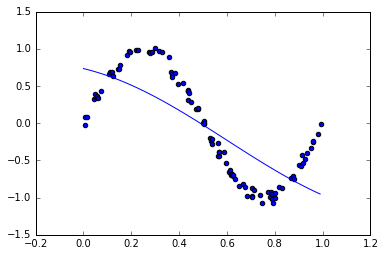

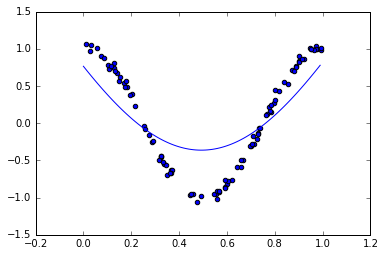

In [16]:
print('unoptimized ll')
lmc = LMC(xss, yss, kernels=[RBF(name='rbf1'),RBF(name='rbf2')], normalize=False)
#lmc.rbf.variance = 1000
print(lmc)
print_diagram()

In [17]:
import scipy.optimize as sciopt
class DerivFree(Optimizer):
    def __init__(self):
        super().__init__()

    def opt(self, x_init, f_fp=None, f=None, fp=None):
        options = {'iprint': 1, 'disp': True, 'maxiter': 1000}
        res = sciopt.minimize(
            f,
            x_init,
            method='COBYLA',
            options=options)
        print(res.message)
        self.x_opt = res.x
    
lmc.optimize(optimizer=DerivFree())
print(np.outer(lmc.a0, lmc.a0))
print(np.outer(lmc.a1, lmc.a1))

Optimization terminated successfully.
[[ 0.56056568 -1.91754751]
 [-1.91754751  6.55942489]]
[[ 3.68872051  1.14714334]
 [ 1.14714334  0.35674642]]



Name : lmc
Objective : -207.55088657050132
Number of Parameters : 10
Number of Optimization Parameters : 10
Updates : True
Parameters:
  lmc.                  |            value  |  constraints  |  priors
  rbf1.variance         |  0.0814186037084  |      +ve      |        
  rbf1.inv_lengthscale  |    13.0254989913  |      +ve      |        
  rbf2.variance         |   0.140214239301  |      +ve      |        
  rbf2.inv_lengthscale  |    12.4682335005  |      +ve      |        
  a0                    |             (2,)  |               |        
  a1                    |             (2,)  |               |        
  noise                 |             (2,)  |      +ve      |        
  index  |     lmc.noise  |  constraints  |  priors
  [0]    |    0.00410160  |      +ve      |        
  [1]    |    0.00144018  |      +ve      |        
  index  |      lmc.a0  |  constraints  |  priors
  [0]    |  0.74870934  |               |        
  [1]    |  -2.56113742  |               |      

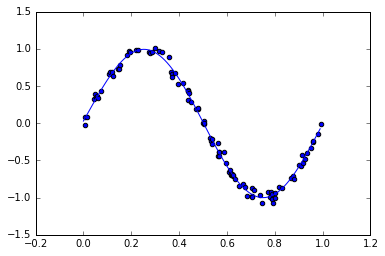

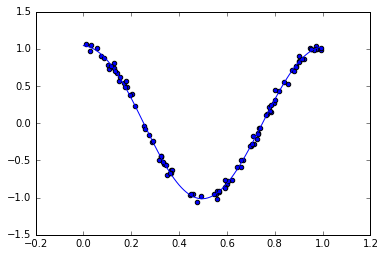

In [18]:
print(lmc)
print(lmc.noise)
print(lmc.a0)
print(lmc.a1)
print_diagram()